# BA 775 B02
# The T is Late: Analyzing MBTA Headway Times

## I. Problem Definition
Headway is defined as the distance between transit vehicles in either space or time. Headway is a good metric for how reliable a transit system is. If headway remains relatively constant across the majority of trips, passengers can count on the train arriving within a specific window of time.

This project aims to analyze the times measured between trains (headway) and identify “problem” stations in order to find simple recommendations to reduce travel time. We also hope to identify a connection between ridership and time spent traveling. We plan to: 

- Identify the line with the worst headway times (normalized)
- Analyze where trains get “caught up” along that specific line
- Evaluate the connection between ridership and headway times.


## II. Executive Summary
This project aims to review the reliability of the MBTA's service through headway performance, specifically the Green-B Line, and investigate the cause of unpredicatable headway. Ultimately, recommendations based on inefficiencies should focus on how consistency in service can be improved.
Our findings indeed show that:
- The Green-B Line stations that cause the most variability in terms of headway are Chestnut Hill Avenue, Warren Street, Harvard Avenue, and Packard's Corner.
- The stations with the most stops made with longer than the official standard headway are the same as stations with the most stops made with shorter than standard headway, suggesting a potential link between different kinds of inconsistency.
- While the Green-B line has the most stops made with longer than expected headway during peak hours, off-peak hours have the most variability in headway from station-to-station, indicating that off-peak service is less predictable or reliable.

The findings, in turn, enable MBTA to make strategic updates for reduced lengthening of headway intervals, consistency in headways, and overall improvement in customer satisfaction. MBTA could optimize its resource allocation by targeting the stations with the longest headways instituting measures that reduce variability, like Transit Signal Priority (TSP).

## III. Data Dictionary & Entity Relationship Diagram
| Table | Column Name | Definition |
| --- | --- | --- | 
| hw_24 | route_id | The Line and Branch of the line that any train is on (Green-B, Red-A, etc.). |
| hw_24 | trunk_route_id | The subway line that any one train is on, regardless of branch (Green-B is Green, Red-A is Red). |
| hw_24 | branch_route_id | The subset of the line that a train is on (Green-B, Green-C). Orange, Blue, and the Northern half of the Red Line have no branches. |
| hw_24 | trip_id | The individual train and an iteration of the route it is taking. |
| hw_24 | direction | The way any one trip is going. |
| hw_24 | stop_name | The name of the station the train has arrived at.|
| hw_24 | stop_departure_sec | The second in the day that a train leaves the stop. |
| hw_24 | stop_departure_datetime | The date and time that the a train leaves the stop. |
| hw_24 | headway_trunk_seconds | The amount of time before the next train of the same trunk arrives at that specific stop. |
| hw_24 | headway_branch_seconds | The amount of time before the next train of the same branch arrives at that specific stop. |
| gse_24 | stop_name| The name of the station. |
| gse_24 | route_or_line| The subway line that any one train is on, regardless of branch (Green-B is Green, Red-A is Red). |
| gse_24 | gated_entries| Number of entries recorded during the listed time period. |
| gse_24 | service_datetime| The date and time of the subway service. |

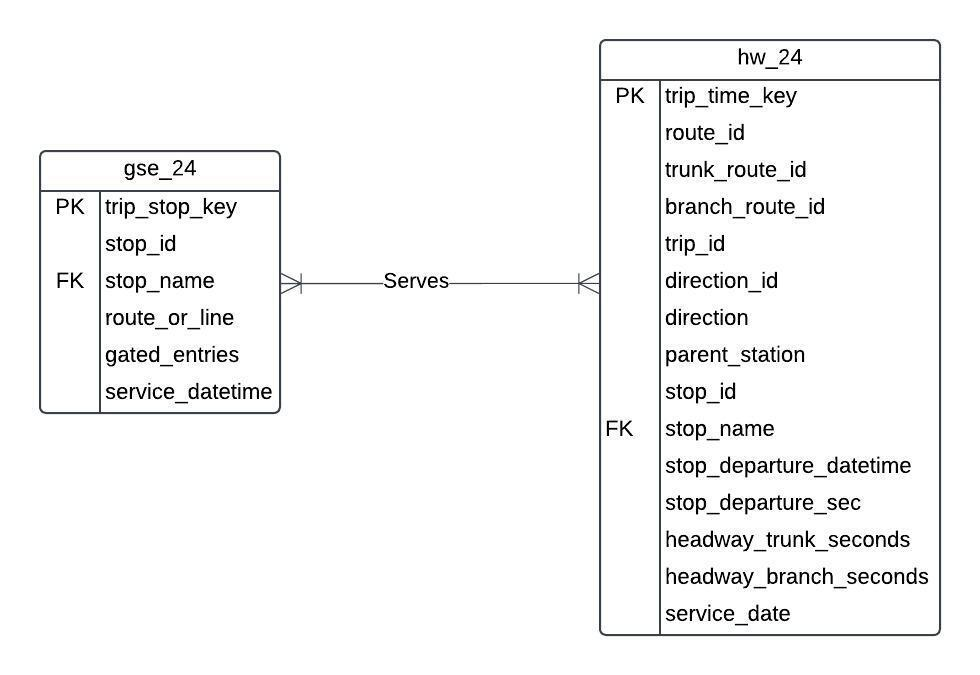

In [4]:
from IPython.display import Image
Image(filename='MBTA_ERD.jpeg')

The table gse_24 measures gated station entries in 30 minute increments at each station. The foreign key that connects this table with the hw_24 table is stop_name. These tables have a many-to-many relationship, as several stops have multiple lines of service. Our data cleaning section will format these tables according to our ERD.

##  IV. Tableau Dashboards

Link to Dashboard for EDA findings:
https://public.tableau.com/app/profile/barrett.ratzlaff/viz/MBTAHeadwayDashboard/EDADashboard?publish=yes

Screenshot of EDA Dashboard:

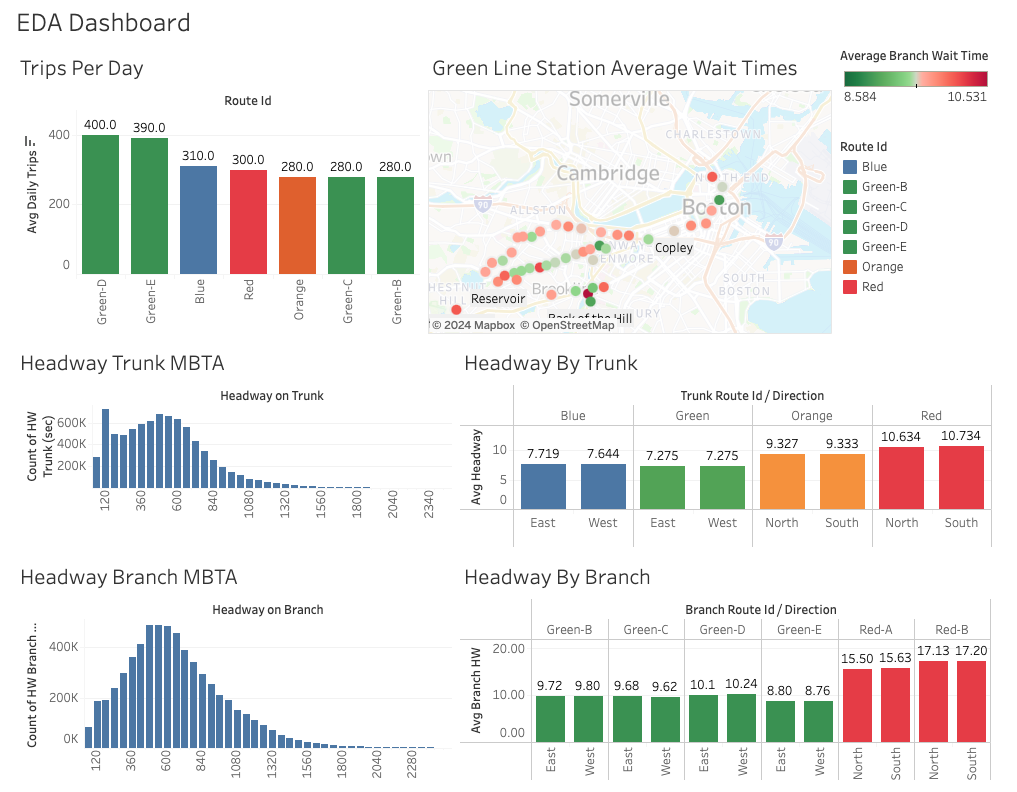

In [5]:
from IPython.display import Image
Image(filename='EDA_Dashboard.png')

Link to Green-B Line Consistency Dashboard: https://public.tableau.com/app/profile/barrett.ratzlaff/viz/Green-BLineConsistencyDashboard/ConsistencyofGreenBLineServicein2024?publish=yes


Screenshot of Dashboard:

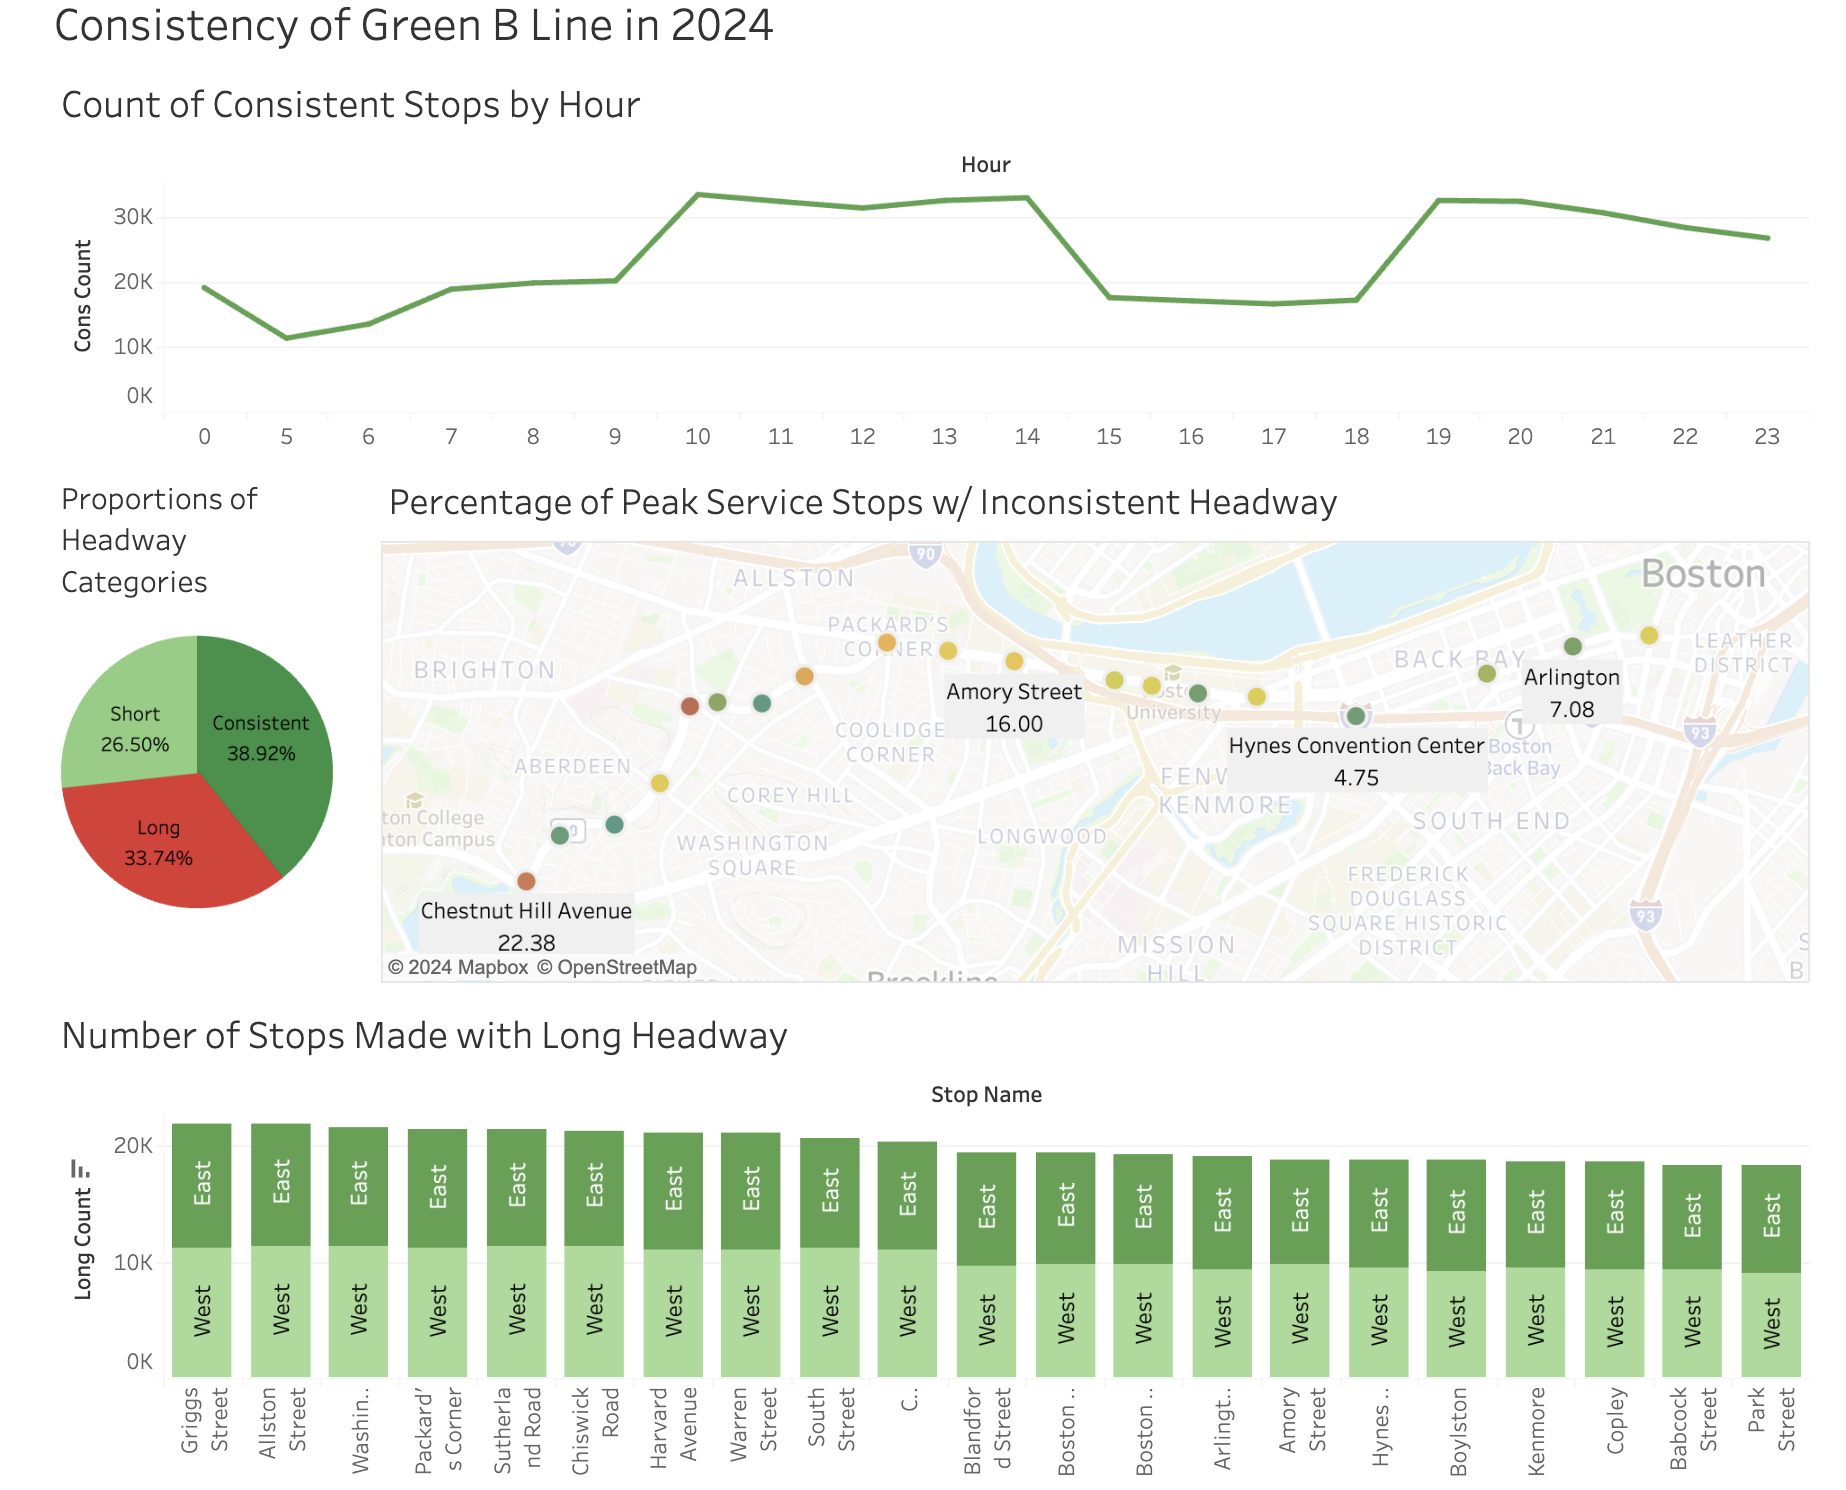

In [6]:
from IPython.display import Image
Image(filename='Green-B_dashboard.png')

## V. Data Cleaning

### 1. Transforming columns and tables
Initially, our data on train headway times was separated by month. For the sake of future querys' clarity, we perform a union on all nine files that we have available.

In [7]:
%%bigquery
CREATE OR REPLACE TABLE `ba-775-team-b2-project.MBTA.hw_24` AS
SELECT * FROM `ba-775-team-b2-project.MBTA.hw_01_24`
UNION ALL
SELECT * FROM `ba-775-team-b2-project.MBTA.hw_02_24`
UNION ALL
SELECT * FROM `ba-775-team-b2-project.MBTA.hw_03_24`
UNION ALL
SELECT * FROM `ba-775-team-b2-project.MBTA.hw_04_24`
UNION ALL
SELECT * FROM `ba-775-team-b2-project.MBTA.hw_05_24`
UNION ALL
SELECT * FROM `ba-775-team-b2-project.MBTA.hw_06_24`
UNION ALL
SELECT * FROM `ba-775-team-b2-project.MBTA.hw_07_24`
UNION ALL
SELECT * FROM `ba-775-team-b2-project.MBTA.hw_08_24`
UNION ALL
SELECT * FROM `ba-775-team-b2-project.MBTA.hw_09_24`

Query is running:   0%|          |

""


In order to make future queries more clear and easier to make, we combined the service_date column and time_period column to make the service_datetime column. In addition, for assigning the primary key, we combined the service_datetime column and stop_id together to ensure the column is unique for every row. 

In [8]:
%%bigquery
SELECT * FROM `ba-775-team-b2-project.MBTA.gse_24`
LIMIT 2

Query is running:   0%|          |

Downloading:   0%|          |

,service_date,time_period,stop_id,station_name,route_or_line,gated_entries
0,2024-09-30,(00:00:00),place-davis,Davis,Red Line,5.0
1,2024-09-30,(01:30:00),place-davis,Davis,Red Line,1.0


In [9]:
%%bigquery
ALTER TABLE `ba-775-team-b2-project.MBTA.gse_24`
DROP COLUMN IF EXISTS service_datetime;

ALTER TABLE `ba-775-team-b2-project.MBTA.gse_24`
ADD COLUMN service_datetime DATETIME;

UPDATE `ba-775-team-b2-project.MBTA.gse_24`
SET service_datetime = DATETIME(CAST(service_date AS STRING) || ' ' || REGEXP_REPLACE(time_period, r"[^\d:]", ""))
WHERE TRUE;

Query is running:   0%|          |

""


In [10]:
%%bigquery
ALTER TABLE `ba-775-team-b2-project.MBTA.gse_24`
DROP COLUMN IF EXISTS trip_stop_key;

ALTER TABLE `ba-775-team-b2-project.MBTA.gse_24`
ADD COLUMN trip_stop_key STRING; 

UPDATE `ba-775-team-b2-project.MBTA.gse_24`
SET trip_stop_key = CONCAT(CAST(service_datetime AS STRING), ' ', stop_id)
WHERE TRUE;

Query is running:   0%|          |

""


In [11]:
%%bigquery
SELECT * FROM `ba-775-team-b2-project.MBTA.gse_24`
LIMIT 2

Query is running:   0%|          |

Downloading:   0%|          |

,service_date,time_period,stop_id,station_name,route_or_line,gated_entries,service_datetime,trip_stop_key
0,2024-09-15,(00:00:00),place-davis,Davis,Red Line,5.0,2024-09-15,2024-09-15 00:00:00 place-davis
1,2024-05-07,(00:00:00),place-davis,Davis,Red Line,5.0,2024-05-07,2024-05-07 00:00:00 place-davis


For assigning the primary key, we combined the stop_departure_datetime column and trip_id together to ensure the column is unique for every row. 

In [12]:
%%bigquery
ALTER TABLE `ba-775-team-b2-project.MBTA.hw_24`
DROP COLUMN IF EXISTS trip_time_key;

ALTER TABLE `ba-775-team-b2-project.MBTA.hw_24`
ADD COLUMN trip_time_key STRING; 

UPDATE `ba-775-team-b2-project.MBTA.hw_24`
SET trip_time_key = CONCAT(CAST(stop_departure_datetime AS STRING), ' ', trip_id)
WHERE TRUE;

Query is running:   0%|          |

""


In [13]:
%%bigquery
SELECT * FROM `ba-775-team-b2-project.MBTA.hw_24`
LIMIT 2

Query is running:   0%|          |

Downloading:   0%|          |

,service_date,route_id,trunk_route_id,branch_route_id,trip_id,direction_id,direction,parent_station,stop_id,stop_name,stop_departure_datetime,stop_departure_sec,headway_trunk_seconds,headway_branch_seconds,trip_time_key
0,2024-09-06,Orange,Orange,None,64072584,0,South,place-grnst,70002,Green Street,2024-09-06T18:22:18Z,66138,661.0,NaN,2024-09-06T18:22:18Z 64072584
1,2024-04-13,Orange,Orange,None,NONREV-1580549674,0,South,place-grnst,70002,Green Street,2024-04-13T07:17:27Z,26247,639.0,NaN,2024-04-13T07:17:27Z NONREV-1580549674


To align the column names to be more similar to the other table, we rename the gated station entry table's "station_name" column to "stop_name".

In [14]:
%%bigquery
ALTER TABLE `ba-775-team-b2-project.MBTA.gse_24`
RENAME COLUMN station_name TO stop_name;

Query is running:   0%|          |

""


In [15]:
%%bigquery
SELECT * FROM `ba-775-team-b2-project.MBTA.gse_24`
LIMIT 2

Query is running:   0%|          |

Downloading:   0%|          |

,service_date,time_period,stop_id,stop_name,route_or_line,gated_entries,service_datetime,trip_stop_key
0,2024-09-15,(00:00:00),place-davis,Davis,Red Line,5.0,2024-09-15,2024-09-15 00:00:00 place-davis
1,2024-05-07,(00:00:00),place-davis,Davis,Red Line,5.0,2024-05-07,2024-05-07 00:00:00 place-davis


In the new combined headway file, the stop_departure_datetime column is initially set as a string. We perform some manipulation for it to be cast as a datetime object for ease of future calculations.

In [16]:
%%bigquery
UPDATE `ba-775-team-b2-project.MBTA.hw_24`
SET stop_departure_datetime = REPLACE(REPLACE(stop_departure_datetime, 'T', ' '), 'Z', '')
WHERE TRUE;

Query is running:   0%|          |

""


In [17]:
%%bigquery
SELECT * from `ba-775-team-b2-project.MBTA.hw_24`
LIMIT 2

Query is running:   0%|          |

Downloading:   0%|          |

,service_date,route_id,trunk_route_id,branch_route_id,trip_id,direction_id,direction,parent_station,stop_id,stop_name,stop_departure_datetime,stop_departure_sec,headway_trunk_seconds,headway_branch_seconds,trip_time_key
0,2024-09-26,Orange,Orange,None,ADDED-1582075893,0,South,place-grnst,70002,Green Street,2024-09-26 23:15:39,83739,616.0,NaN,2024-09-26T23:15:39Z ADDED-1582075893
1,2024-03-23,Orange,Orange,None,59669259,0,South,place-grnst,70002,Green Street,2024-03-23 18:08:55,65335,516.0,NaN,2024-03-23T18:08:55Z 59669259


In [18]:
%%bigquery
ALTER TABLE `ba-775-team-b2-project.MBTA.hw_24`
ADD COLUMN new_stop_departure_datetime DATETIME;

UPDATE `ba-775-team-b2-project.MBTA.hw_24`
SET new_stop_departure_datetime = CAST(stop_departure_datetime AS DATETIME)
WHERE TRUE;

ALTER TABLE `ba-775-team-b2-project.MBTA.hw_24`
DROP COLUMN stop_departure_datetime;

ALTER TABLE `ba-775-team-b2-project.MBTA.hw_24`
RENAME COLUMN new_stop_departure_datetime TO stop_departure_datetime;

Query is running:   0%|          |

""


In [19]:
%%bigquery
SELECT * FROM `ba-775-team-b2-project.MBTA.hw_24`
LIMIT 2

Query is running:   0%|          |

Downloading:   0%|          |

,service_date,route_id,trunk_route_id,branch_route_id,trip_id,direction_id,direction,parent_station,stop_id,stop_name,stop_departure_sec,headway_trunk_seconds,headway_branch_seconds,trip_time_key,stop_departure_datetime
0,2024-02-21,Orange,Orange,None,NONREV-1580534883,0,South,place-grnst,70002,Green Street,25018,508.0,NaN,2024-02-21T06:56:58Z NONREV-1580534883,2024-02-21 06:56:58
1,2024-01-03,Orange,Orange,None,60455480,0,South,place-grnst,70002,Green Street,83349,589.0,NaN,2024-01-03T23:09:09Z 60455480,2024-01-03 23:09:09


Now that the above queries have been made, it is appropriate to remove redundant columns.

The original two columns, service_date and time_period, are now redundant and can be removed.

In [20]:
%%bigquery
ALTER TABLE `ba-775-team-b2-project.MBTA.gse_24`
DROP COLUMN service_date

Query is running:   0%|          |

""


In [21]:
%%bigquery
ALTER TABLE `ba-775-team-b2-project.MBTA.gse_24`
DROP COLUMN time_period

Query is running:   0%|          |

""


direction_id, either a 1 or a 0, is not necessarily as clear as the direction column, which explicitly states the trip's direction. We therefore remove the direction_id column.

parent_station is a shorthand for the station name, which is already contained in station_name. This is redundant and can be removed.

stop_id's data is inconsistent due to the shutdowns of the MBTA in the past year. Additionally, a few other columns together can provide the same information as stop_id (which stop & which direction). Thus, we drop the stop_id column.

Finally, all of the information contained in the service_date column is also contained in the corresponding stop_departure_datetime column. For this reason, we can remove service_date.

In [22]:
%%bigquery
ALTER TABLE `ba-775-team-b2-project.MBTA.hw_24`
DROP COLUMN direction_id,
DROP COLUMN parent_station,
DROP COLUMN stop_id,
DROP COLUMN service_date;

Query is running:   0%|          |

""


### 2. Addressing Erroneous Data and Null Values
Due to train operator error, there are several Green Line rows where the route ID is listed incorrectly. In other words, the train operator accidentally registers the train as an Green E Line train for a station on the B Line. This skews results and makes our aggregations messy, so we created a reference table to ensure all rows contain the route ID that matches the station the train is at. An example of the issue described is shown below.

We also make leave the terminal stations out of the reference table. Firstly, the MBTA does not record it intentionally (only a few records on accident), and secondly, headway is less important at the end of the line since there are no further stations past the terminal one.

In [23]:
%%bigquery
SELECT route_id, stop_name, trip_id 
FROM `ba-775-team-b2-project.MBTA.hw_24`
WHERE stop_name = 'Sutherland Road' AND route_id = 'Green-C'

Query is running:   0%|          |

Downloading:   0%|          |

,route_id,stop_name,trip_id
0,Green-C,Sutherland Road,ADDED-1582054283
1,Green-C,Sutherland Road,62922645


In [24]:
%%bigquery
SELECT route_id, stop_name, trip_id 
FROM `ba-775-team-b2-project.MBTA.hw_24`
WHERE trip_id = 'ADDED-1582054283'

Query is running:   0%|          |

Downloading:   0%|          |

,route_id,stop_name,trip_id
0,Green-C,Sutherland Road,ADDED-1582054283


Sutherland Road is a station along the B Line, but the route_id is listed as Green C. The second query demonstrates that this error typically only happens for one station. There are only two records of this specific error taking place in 2024, but this kind of error happens elsewhere along the Green Line system. In order for our calculations to be accurate, using a reference table to filter out these errors is important.

In [25]:
%%bigquery
CREATE OR REPLACE TABLE `ba-775-team-b2-project.MBTA.station_train_mapping` (
    route_id STRING(50) NOT NULL,
    stop_name STRING(50) NOT NULL,
);

INSERT INTO `ba-775-team-b2-project.MBTA.station_train_mapping` (route_id, stop_name) VALUES
('Orange','Green Street'), ('Orange','Stony Brook'), ('Orange', 'Jackson Square'),
('Orange','Roxbury Crossing'), ('Orange','Ruggles'), ('Orange','Massachusetts Avenue'),
('Orange','Back Bay'), ('Orange','Tufts Medical Center'), ('Orange','Chinatown'),
('Orange','Downtown Crossing'), ('Orange','State'), ('Orange','Haymarket'),
('Orange','North Station'), ('Orange','Community College'), ('Orange', 'Sullivan Square'),
('Orange', 'Assembly'), ('Orange', 'Wellington'), ('Orange', 'Malden Center'), 

('Blue','Government Center'),('Blue','State'),('Blue','Aquarium'),('Blue','Maverick'),('Blue','Airport'), ('Blue', 'Wood Island'),
('Blue','Orient Heights'),('Blue','Suffolk Downs'),('Blue','Beachmont'),('Blue','Revere Beach'),

('Red','Davis'),('Red','Porter'),('Red','Harvard'),('Red','Central'),
('Red','Kendall/MIT'),('Red','Charles/MGH'),('Red','Park Street'),('Red','Downtown Crossing'),('Red','South Station'),
('Red','Broadway'),('Red','Andrew'),('Red','JFK/UMass'),
('Red','North Quincy'),('Red','Wollaston'),('Red','Quincy Center'),
('Red','Quincy Adams'),('Red','Savin Hill'),('Red','Fields Corner'),('Red', 'Shawmut'),

('Green-B','South Street'),('Green-B','Chestnut Hill Avenue'),('Green-B','Chiswick Road'),('Green-B','Sutherland Road'),
('Green-B','Washington Street'),('Green-B','Warren Street'),('Green-B','Allston Street'),('Green-B','Griggs Street'),('Green-B','Harvard Avenue'),
('Green-B',"Packard's Corner"),('Green-B','Babcock Street'),('Green-B','Amory Street'),('Green-B','Boston University Central'),
('Green-B','Boston University East'),('Green-B','Blandford Street'),('Green-B','Kenmore'),('Green-B','Hynes Convention Center'),
('Green-B','Copley'),('Green-B','Arlington'),('Green-B','Boylston'), ('Green-B','Park Street'),

('Green-C','Englewood Avenue'),('Green-C','Dean Road'),('Green-C','Tappan Street'),('Green-C','Washington Square'),('Green-C','Fairbanks Street'),
('Green-C','Brandon Hall'),('Green-C','Summit Avenue'),('Green-C','Coolidge Corner'),('Green-C','Saint Paul Street'),('Green-C','Kent Street'),
('Green-C','Hawes Street'),('Green-C',"Saint Mary's Street"),('Green-C','Kenmore'),('Green-C','Hynes Convention Center'),
('Green-C','Copley'),('Green-C','Arlington'),('Green-C','Boylston'),('Green-C','Park Street'),

('Green-D','Woodland'),('Green-D','Waban'),('Green-D','Eliot'),('Green-D','Newton Highlands'),('Green-D','Newton Centre'),
('Green-D','Chestnut Hill'),('Green-D','Reservoir'),('Green-D','Beaconsfield'),('Green-D','Brookline Hills'),('Green-D','Brookline Village'),
('Green-D','Longwood'),('Green-D','Fenway'),('Green-D','Kenmore'),('Green-D','Hynes Convention Center'),
('Green-D','Copley'),('Green-D','Arlington'),('Green-D','Boylston'),('Green-D','Park Street'),('Green-D','Government Center'),
('Green-D','Haymarket'),('Green-D','North Station'),('Green-D','Science Park/West End'),('Green-D','Lechmere'),

('Green-E','Back of the Hill'),('Green-E','Riverway'),('Green-E','Mission Park'),('Green-E','Fenwood Road'),
('Green-E','Brigham Circle'),('Green-E','Longwood Medical Area'),('Green-E','Museum of Fine Arts'),('Green-E','Northeastern'),
('Green-E','Symphony'),('Green-E','Prudential'),('Green-E','Copley'),('Green-E','Arlington'),('Green-E','Boylston'),
('Green-E','Park Street'),('Green-E','Government Center'),('Green-E','Haymarket'),('Green-E','North Station'),
('Green-E','Science Park/West End'),('Green-E','Lechmere'),('Green-E','East Somerville'),('Green-E','Gilman Square'),
('Green-E','Magoun Square'),('Green-E','Ball Square')


Query is running:   0%|          |

""


In [26]:
%%bigquery
DELETE FROM `ba-775-team-b2-project.MBTA.hw_24`
WHERE (route_id, stop_name) NOT IN (
    SELECT (route_id, stop_name) FROM `ba-775-team-b2-project.MBTA.station_train_mapping`);

Query is running:   0%|          |

""


There are null values within headway_trunk_seconds and headway_branch seconds for several reasons.

Headway_trunk_seconds not being recorded can happen due to a train hard resetting partway through the trip. This is especially common on the Green Line, where trains from the 1980s are commonly run and are more exposed to the elements than trains from other lines.

Thankfully, stop_departure_datetime has no null values at all. Using the next stop_departure_datetime associated with the train behind the train with a null value, we can safely calculate headway. To be careful, we set conditionals that prevent headway from being calculated if the preceding train was from the day before. This prevents any calculations skewing upwards.

In [27]:
%%bigquery
CREATE OR REPLACE TABLE `ba-775-team-b2-project.MBTA.hw_24` AS

WITH
  manual_headway AS (
  SELECT
    *,
    LAG(CAST(stop_departure_datetime AS DATETIME)) OVER (PARTITION BY trunk_route_id, stop_name, direction ORDER BY CAST(stop_departure_datetime AS DATETIME)) AS preceding_train_departure_datetime
  FROM
    `ba-775-team-b2-project.MBTA.hw_24` ),
  full_headway AS (
  SELECT
    *,
CASE
    WHEN headway_trunk_seconds IS NULL 
         AND EXTRACT(HOUR FROM preceding_train_departure_datetime) NOT BETWEEN 0 AND 2
         AND EXTRACT(HOUR FROM stop_departure_datetime) NOT BETWEEN 4 AND 6 AND
         EXTRACT(DAY FROM stop_departure_datetime) = EXTRACT(DAY FROM preceding_train_departure_datetime)
    THEN TIMESTAMP_DIFF(CAST(stop_departure_datetime AS DATETIME), preceding_train_departure_datetime, SECOND)
    ELSE headway_trunk_seconds
END
    AS impute_headway
  FROM
    manual_headway )
SELECT
  m.*,
  f.preceding_train_departure_datetime,
  impute_headway
FROM
  full_headway AS f
RIGHT JOIN
  `ba-775-team-b2-project.MBTA.hw_24` AS m
ON
  f.stop_departure_datetime = m.stop_departure_datetime
  AND f.trip_id = m.trip_id
  AND f.stop_name = m.stop_name

Query is running:   0%|          |

""


When imputing branch headway, the process needs to be done carefully to ensure it only applies to the lines with branches. Otherwise, we have unnecessary or misleading information in the column for branch headway. The below query is an adjusted version of the previous query.

In [28]:
%%bigquery
CREATE OR REPLACE TABLE `ba-775-team-b2-project.MBTA.hw_24` AS

WITH
  manual_headway AS (
  SELECT
    *,
    LAG(CAST(stop_departure_datetime AS DATETIME)) OVER (PARTITION BY branch_route_id, stop_name, direction ORDER BY CAST(stop_departure_datetime AS DATETIME)) AS preceding_branch_departure_datetime
  FROM
    `ba-775-team-b2-project.MBTA.hw_24` 
    WHERE branch_route_id LIKE '%-%'), #Lines with branches have '-' in id
  full_headway AS (
  SELECT
    *,
CASE
    WHEN headway_branch_seconds IS NULL 
         AND EXTRACT(HOUR FROM preceding_branch_departure_datetime) NOT BETWEEN 0 AND 2
         AND EXTRACT(HOUR FROM stop_departure_datetime) NOT BETWEEN 4 AND 6 AND
         EXTRACT(DAY FROM stop_departure_datetime) = EXTRACT(DAY FROM preceding_branch_departure_datetime)
    THEN TIMESTAMP_DIFF(CAST(stop_departure_datetime AS DATETIME), preceding_branch_departure_datetime, SECOND)
    ELSE headway_branch_seconds
END
    AS impute_branch_headway
  FROM
    manual_headway )
SELECT
  m.*,
  f.preceding_branch_departure_datetime,
  impute_branch_headway
FROM
  full_headway AS f
RIGHT JOIN
  `ba-775-team-b2-project.MBTA.hw_24` AS m
ON
  f.stop_departure_datetime = m.stop_departure_datetime
  AND f.trip_id = m.trip_id
  AND f.stop_name = m.stop_name

Query is running:   0%|          |

""


In [29]:
%%bigquery
ALTER TABLE `ba-775-team-b2-project.MBTA.hw_24`
DROP COLUMN headway_trunk_seconds,
DROP COLUMN headway_branch_seconds,
DROP COLUMN preceding_train_departure_datetime, 
DROP COLUMN preceding_branch_departure_datetime

Query is running:   0%|          |

""


In [30]:
%%bigquery
ALTER TABLE `ba-775-team-b2-project.MBTA.hw_24`
RENAME COLUMN impute_headway TO headway_trunk_seconds,
RENAME COLUMN impute_branch_headway TO headway_branch_seconds

Query is running:   0%|          |

""


## VI. EDA

### 1. Subway Overview
First, it is helpful to briefly explain the subway/lightrail system in Boston.

In [31]:
%%bigquery
SELECT DISTINCT trunk_route_id AS Trunk, branch_route_id AS Branch
FROM `ba-775-team-b2-project.MBTA.hw_24`
ORDER BY branch_route_id DESC

Query is running:   0%|          |

Downloading:   0%|          |

,Trunk,Branch
0,Red,Red-B
1,Red,Red-A
2,Green,Green-E
3,Green,Green-D
4,Green,Green-C
5,Green,Green-B
6,Red,None
7,Orange,None
8,Blue,None


Boston's subway/lightrail system has four distinct lines - Red, Blue, Orange, and Green.

All of these lines are considered "trunks" but only the Red and Green line have "branches". The Red line only has two branches to Ashmont (A) and Braintree (B), exclusively on the southern end of the line.

The Green Line has 4 branches, with 2 branches stretching past both ends of the Green trunk (D & E). The Green B Line and C Line only extend on the western end of the Green trunk.

For Orange Line and Blue Line trains, headway is a straightforward measurement. The amount of time it takes for one train to arrive at a stop behind the train in front of it is the headway time.

For portions of the Green Line and Red Line, there are two headways to be calculated: The headway between a train and the next train regardless of branch, and the headway between a train and the next train of the same branch. This will become more clear as our analysis progresses.

On average, how frequently do these trains run daily?

### 2. Trips per Day

In [32]:
%%bigquery
WITH dates AS (
  SELECT trip_id, route_id, EXTRACT(MONTH FROM stop_departure_datetime) AS month, EXTRACT(DAY FROM stop_departure_datetime) AS day
FROM `ba-775-team-b2-project.MBTA.hw_24`
),


trips AS (
SELECT (COUNT(DISTINCT trip_id)) AS trip_count, route_id, month, day
FROM dates
GROUP BY route_id, month, day
)

SELECT ROUND(AVG(trip_count),-1) AS avg_daily_trips, route_id
FROM trips
GROUP BY route_id
ORDER BY avg_daily_trips DESC

Query is running:   0%|          |

Downloading:   0%|          |

,avg_daily_trips,route_id
0,400.0,Green-D
1,390.0,Green-E
2,310.0,Blue
3,300.0,Red
4,280.0,Orange
5,280.0,Green-C
6,280.0,Green-B


The Green D Line by far is the most common, which makes sense due to the small size of Green Line cars, and the Green D line being the longest branch of the Green "trunk". The Green E line is close in second. Both Green-D and Green-E branches extend on either ends of the Green Line, so it is reasonable for these lines to run trains more frequently than other lines.

Interestingly, the Green B line runs a small amount of trains compared to the other lines despite serving two college communities and being one of very few public transit options in Brighton, a whole neighborhood of Boston.

In [33]:
%%bigquery
SELECT trunk_route_id, branch_route_id, COUNT(DISTINCT stop_name) AS stop_num
FROM `ba-775-team-b2-project.MBTA.hw_24`
GROUP BY trunk_route_id, branch_route_id
ORDER BY stop_num DESC

Query is running:   0%|          |

Downloading:   0%|          |

,trunk_route_id,branch_route_id,stop_num
0,Green,Green-D,23
1,Green,Green-E,22
2,Green,Green-B,21
3,Red,Red-B,19
4,Green,Green-C,18
5,Orange,None,18
6,Red,Red-A,15
7,Red,None,11
8,Blue,None,10


Looking at the amount of stations covered by each of the lines, it's evident why the Green Line runs so frequently in comparison to the other lines. A plausible explanation for the low daily frequency of Blue Line trains also emerges-- amongst all the modern subway lines in Boston, they have the fewest stations. With fewer stations, less trains likely need to be on the line to accommodate a similar amount of demand.

Seeing how frequently trains run daily on each line give a vague idea of how reliable a line's service is, but headway would be a better metric to investigate. First, let's look at the headway within the trunks of each line.

### 3. Headways

#### 3a. Headway by Line

In [34]:
%%bigquery
SELECT trunk_route_id, direction, ROUND(AVG(headway_trunk_seconds)/60, 2) AS avg_hw_min FROM `ba-775-team-b2-project.MBTA.hw_24`
GROUP BY trunk_route_id, direction
ORDER BY avg_hw_min DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,trunk_route_id,direction,avg_hw_min
0,Red,South,10.73
1,Red,North,10.63
2,Orange,North,9.33
3,Orange,South,9.33
4,Blue,East,7.72
5,Blue,West,7.64
6,Green,West,7.27
7,Green,East,7.27


Looking at the chart above, it appears that the Green Line has the shortest headway times at <7.5 minutes. However, this also calculates headway within the Red and Green Line "trunks", where multiple lines converge into one tunnel. Headway times are likely incredibly short in those tunnels, but longer in the branches of the lines. For Orange and Blue Line trains, this is a fine estimate of their headway times, but one must look at the branch headway times to gain a deeper understanding of the Green and Red lines. 

In [35]:
%%bigquery
SELECT branch_route_id, direction, ROUND(AVG(headway_branch_seconds)/60, 2) AS avg_hw_min FROM `ba-775-team-b2-project.MBTA.hw_24`
GROUP BY branch_route_id, direction
HAVING branch_route_id IS NOT NULL
ORDER BY avg_hw_min DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,branch_route_id,direction,avg_hw_min
0,Red-B,South,17.20
1,Red-B,North,17.13
2,Red-A,South,15.63
3,Red-A,North,15.50
4,Green-D,West,10.24
5,Green-D,East,10.01
6,Green-B,West,9.80
7,Green-B,East,9.72
8,Green-C,East,9.68
9,Green-C,West,9.62


As expected, the branches have a higher average headway time when looking for the next train of the same line. The Red Line branches have significantly higher headway times when not considering the trunk. Green Line branches also have a longer headway when comparing to the Green trunk.

While a 17 minute wait for a train is not ideal from a passenger's perspective, it is important to consider that a typical Red Line train can hold nearly four times as many passengers as a Green Line car. In order to satisfy a similar amount of demand, Green Line trains must run more frequently than Red Line trains. How can we normalize for this?

https://en.wikipedia.org/wiki/MBTA_CAF_USA_Type_9

https://en.wikipedia.org/wiki/Red_Line_(MBTA)#1963_Pullman_cars

According to these pages, the capacity of Green Line and Red Line cars can seat about 200. Green Line normally runs two cars for each train, and Red Line typically runs six cars. So, if a train is close to crush capacity, a Green Line train can hold 400 people, and a Red Line train can hold about 1200.

What this indicates is that despite the lower headway, the Green Line is not necessarily more efficient at tranporting passengers.

#### 3b. Headway by Station

In [36]:
%%bigquery
SELECT stop_name, trunk_route_id,
AVG(headway_trunk_seconds)/60 AS avg_wait_time_trunk,
AVG(headway_branch_seconds)/60 AS avg_wait_time_branch
FROM
  `ba-775-team-b2-project.MBTA.hw_24`
WHERE trunk_route_id = 'Red'
GROUP BY
trunk_route_id, stop_name
HAVING avg_wait_time_trunk IS NOT NULL
ORDER BY avg_wait_time_trunk DESC, avg_wait_time_branch DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,stop_name,trunk_route_id,avg_wait_time_trunk,avg_wait_time_branch
0,North Quincy,Red,17.223412,17.223412
1,Quincy Adams,Red,17.107503,17.107503
2,Quincy Center,Red,17.084259,17.084259
3,Wollaston,Red,17.076103,17.076103
4,Savin Hill,Red,15.574281,15.574680
5,Shawmut,Red,15.567736,15.568129
6,Fields Corner,Red,15.550603,15.550996
7,Davis,Red,9.170939,16.039664
8,Kendall/MIT,Red,9.000854,16.347369
9,Harvard,Red,8.936967,16.072915


On the Red Line, average wait time at each station predictably goes down as the trains enter the trunk and passengers can board two different changes. There is some fluctuation though from station to station in branch headway. Does the Green Line have similar patterns?

In [37]:
%%bigquery
SELECT stop_name, branch_route_id,
ROUND(AVG(headway_trunk_seconds)/60,2) AS avg_wait_time_trunk,
ROUND(AVG(headway_branch_seconds)/60,2) AS avg_wait_time_branch
FROM
  `ba-775-team-b2-project.MBTA.hw_24`
WHERE branch_route_id = 'Green-B'
GROUP BY
branch_route_id, stop_name
HAVING avg_wait_time_trunk IS NOT NULL
ORDER BY avg_wait_time_trunk DESC, avg_wait_time_branch DESC

Query is running:   0%|          |

Downloading:   0%|          |

,stop_name,branch_route_id,avg_wait_time_trunk,avg_wait_time_branch
0,Babcock Street,Green-B,9.84,9.84
1,Blandford Street,Green-B,9.80,9.80
2,Allston Street,Green-B,9.71,9.71
3,Griggs Street,Green-B,9.71,9.71
4,Harvard Avenue,Green-B,9.70,9.70
5,Warren Street,Green-B,9.70,9.70
6,Sutherland Road,Green-B,9.70,9.70
7,Chiswick Road,Green-B,9.70,9.70
8,Chestnut Hill Avenue,Green-B,9.69,9.69
9,Packard's Corner,Green-B,9.69,9.69


We see a similar level of fluctuation on a branch of the Green Line as well, with trunk headway dropping significantly in the unifying tunnel, with some minor fluctuation along the above-ground portion of the line.

We've seen the differences along the station, but there is an important distinction to check: time of day. The MBTA typically gives each line a range of when to expect the next train (Green Line B can expect trains every 6 - 12 minutes according to the MBTA).

#### 3c. Headway by Hour of Day

In [38]:
%%bigquery
SELECT trunk_route_id, EXTRACT(HOUR FROM TIMESTAMP(stop_departure_datetime)) AS hour_of_day,
  AVG(headway_trunk_seconds)/60 AS avg_headway_trunk,
  AVG(headway_branch_seconds)/60 AS avg_headway_branch
FROM
  `ba-775-team-b2-project.MBTA.hw_24`
WHERE
  (headway_trunk_seconds IS NOT NULL OR headway_branch_seconds IS NOT NULL) AND trunk_route_id = 'Green'
GROUP BY
  hour_of_day, trunk_route_id
HAVING hour_of_day <> 3 ## No service at this hour
ORDER BY
  hour_of_day;


Query is running:   0%|          |

Downloading:   0%|          |

,trunk_route_id,hour_of_day,avg_headway_trunk,avg_headway_branch
0,Green,0,9.133994,12.051875
1,Green,1,16.695801,20.284299
2,Green,4,4.527278,4.535266
3,Green,5,6.761801,8.318076
4,Green,6,7.222734,9.646327
5,Green,7,7.078090,9.302070
6,Green,8,6.901353,9.084811
7,Green,9,6.734386,8.856672
8,Green,10,6.695063,8.804530
9,Green,11,6.820014,8.967352


Interestingly, branch headway increases during rush hours, decreases after, before increasing by midday. Branch headway is at its slowest at the very end of service.

### 4. Headway and Gated Station Entry Correlation
At this point, it's worth considering the impact of headway on use of the MBTA's subway services. Do people tend to not use the subway when headway times are long? In order to measure correlation, we must join our gated station entries table and our headway table.

In [39]:
%%bigquery
WITH timestamp AS 
(SELECT headway_trunk_seconds, stop_name, headway_branch_seconds, TIMESTAMP_TRUNC(TIMESTAMP(stop_departure_datetime),HOUR) AS stoptime
FROM `ba-775-team-b2-project.MBTA.hw_24`),

gse AS
(SELECT stop_name, gated_entries, TIMESTAMP(service_datetime) AS service_timestamp
FROM `ba-775-team-b2-project.MBTA.gse_24`),

sum_entries AS ##converging rows that are thirty minute intervals
(SELECT stop_name, SUM(gated_entries) AS total_entries, TIMESTAMP_TRUNC(service_timestamp, HOUR) AS hour
FROM gse
GROUP BY stop_name, hour)

SELECT ROUND(CORR(headway_trunk_seconds, total_entries),2) AS headway_entry_corr FROM timestamp
LEFT JOIN sum_entries
ON timestamp.stop_name = sum_entries.stop_name AND timestamp.stoptime = sum_entries.hour

Query is running:   0%|          |

Downloading:   0%|          |

,headway_entry_corr
0,-0.17


There is a very weak negative correlation between gated entries and headway times. This intuitively makes sense. The people that take the subway typically do so because it is the most cost-effective option, or the only option at all.

Does this change when viewing correlation within individual routes?

In [40]:
%%bigquery
WITH timestamp AS 
(SELECT route_id, headway_trunk_seconds, stop_name, headway_branch_seconds, TIMESTAMP_TRUNC(TIMESTAMP(stop_departure_datetime),HOUR) AS stoptime
FROM `ba-775-team-b2-project.MBTA.hw_24`),

gse AS
(SELECT stop_name, gated_entries, TIMESTAMP(service_datetime) AS service_timestamp
FROM `ba-775-team-b2-project.MBTA.gse_24`),

sum_entries AS ##converging rows that are thirty minute intervals
(SELECT stop_name, SUM(gated_entries) AS total_entries, TIMESTAMP_TRUNC(service_timestamp, HOUR) AS hour
FROM gse
GROUP BY stop_name, hour)

SELECT timestamp.route_id, CORR(headway_trunk_seconds, total_entries) AS headway_entry_corr FROM timestamp
LEFT JOIN sum_entries
ON timestamp.stop_name = sum_entries.stop_name AND timestamp.stoptime = sum_entries.hour
GROUP BY route_id
ORDER BY headway_entry_corr DESC

Query is running:   0%|          |

Downloading:   0%|          |

,route_id,headway_entry_corr
0,Green-B,-0.040966
1,Green-D,-0.049761
2,Green-C,-0.059107
3,Orange,-0.142230
4,Blue,-0.178193
5,Red,-0.236461
6,Green-E,-0.249923


An important caveat with this table is that the majority of Green Line stops are not gated, and so their entries are not measured in the same way as gated stops. That said, the negative correlation is still quite weak amongst all lines.

The inflexible demand for the MBTA subway service indicates that people are dependent on the MBTA as a form of transportation. For lines like the Green B line or Red Line, there are not many alternatives for transit if the lightrail or subway is not reliable.

## VII. Next Steps

We have so far inspected the averages of headway across the MBTA by various metrics: Line of service, time of day, and individual stops. Additionally, it has also been clear that despite high headway, passengers tend to still use the MBTA, indicating the importance of public transit to Boston's city infrastructure.

Next, we will focus on purely the Green-B line and measure headway by different metrics like standard deviation and categorizing trips by headway length to get a better sense of how service consistency varies across the line. By identifying problem stations through these metrics, our recommendations can become more targeted.

### 1. Categorizing Headway

#### 1a. Long Headway
During peak service, the MBTA's website (https://www.mbta.com/schedules/Green-B/line) states that passengers can expect trains from the Green-B line every 6 - 8 minutes during peak service, and 7 - 12 minutes during off-peak service. We will use this to categorize each stop of a trip to define their headway as short, long, or consistent.

First, let's see how many trips run with longer than expected headway during peak hours. Peak hours are listed as 6:00 a.m. to 9:00 a.m. and 3:00 p.m. to 6:00 p.m. on the MBTA website. We will create conditions based on that.

In [41]:
%%bigquery
WITH info AS (SELECT
    route_id,
    stop_name,
    EXTRACT(HOUR FROM stop_departure_datetime) as hour,
    headway_branch_seconds,
    COUNT(stop_name) OVER() AS total_stops,
    direction
FROM `ba-775-team-b2-project.MBTA.hw_24`
WHERE route_id IN ('Green-B')),

categories AS (
    SELECT
    stop_name, direction, hour, headway_branch_seconds, total_stops,
    CASE ## strictly counting peak hour service
        WHEN headway_branch_seconds < 360 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 360 AND 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'long'
        ELSE NULL
    END AS headway_category
FROM info)

SELECT ROUND((COUNT(headway_category)/AVG(total_stops))*100,2) AS long_peak_stops_pct  # Average of the total_stops is just total_stops 
FROM categories
WHERE headway_category = 'long'

Query is running:   0%|          |

Downloading:   0%|          |

,long_peak_stops_pct
0,20.69


Of all Green-B Line stops made in 2024, 20% of those stops had longer than expected headways and were during peak service, when demand is at its highest. Adding off-peak trips, the inconsistency increases.

In [42]:
%%bigquery
WITH info AS (SELECT
    route_id,
    stop_name,
    EXTRACT(HOUR FROM stop_departure_datetime) as hour,
    headway_branch_seconds,
    COUNT(stop_name) OVER() AS total_stops,
    direction
FROM `ba-775-team-b2-project.MBTA.hw_24`
WHERE route_id IN ('Green-B')),

categories AS (
    SELECT
    stop_name, direction, hour, headway_branch_seconds, total_stops,
    CASE ## counting peak and off-peak service
        WHEN headway_branch_seconds < 360 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'Short'
        WHEN headway_branch_seconds BETWEEN 360 AND 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'Consistent'
        WHEN headway_branch_seconds > 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'Long'
        WHEN headway_branch_seconds < 420 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'Short'
        WHEN headway_branch_seconds BETWEEN 420 AND 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'Consistent'
        WHEN headway_branch_seconds > 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'Long'
        ELSE NULL
    END AS headway_category
FROM info)

SELECT headway_category, ROUND(COUNT(headway_category)/AVG(total_stops)*100,2) AS long_stops_pct  # Average of the total_stops is just total_stops 
FROM categories
GROUP BY headway_category

Query is running:   0%|          |

Downloading:   0%|          |

,headway_category,long_stops_pct
0,None,0.00
1,Long,33.74
2,Short,26.50
3,Consistent,38.92


Over 33% of all stops made by the Green-B Line in 2024 are made with longer than expected headway, which is also indicative of total wait time between trains. This is hardly consistent service. That said, it is unlikely that the unpredictable nature of the Green B Line is equally distributed across the line. Let's now see how where these stops with long headway happen the most frequently.

In [43]:
%%bigquery
WITH info AS (SELECT
    route_id,
    stop_name,
    EXTRACT(HOUR FROM stop_departure_datetime) as hour,
    headway_branch_seconds,
    direction
FROM `ba-775-team-b2-project.MBTA.hw_24`
WHERE route_id IN ('Green-B')),

categories AS (
    SELECT
    stop_name, direction, hour, headway_branch_seconds,
    CASE 
        WHEN headway_branch_seconds < 360 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 360 AND 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'long'
        WHEN headway_branch_seconds < 420 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 420 AND 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'long'
        ELSE NULL
    END AS headway_category
FROM info)

SELECT stop_name, direction, RANK() OVER(ORDER BY COUNT(headway_category) DESC) AS long_rank, COUNT(headway_category) AS long_count
FROM categories
WHERE headway_category = 'long'
GROUP BY stop_name, direction, headway_category
ORDER BY long_rank ASC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,stop_name,direction,long_rank,long_count
0,Chiswick Road,West,1,11418
1,Sutherland Road,West,2,11354
2,Washington Street,West,3,11294
3,Allston Street,West,4,11287
4,Griggs Street,West,5,11244
5,South Street,West,6,11218
6,Packard's Corner,West,7,11167
7,Harvard Avenue,West,8,11089
8,Warren Street,West,9,11020
9,Chestnut Hill Avenue,West,10,11012


All ten of the stations that most frequently have longer waits than usual are all on the outbound side, heading towards Boston College. Nine of those stations are past the Commonwealth Avenue portion of the line's service. While it is impossible to establish causality with specific factors and these longer headways, one possible factor to consider could be the change in geography from Packcard's Corner onwards. 

Starting from Babcock Street towards Boston College station, there are more abnormal intersection street light patterns and hillier terrain. The geography could hinder the progress of trains as they move towards Boston College.

Let's inverse this table to see which stops have the most infrequent longer than expected headways.

In [44]:
%%bigquery
WITH info AS (SELECT
    route_id,
    stop_name,
    EXTRACT(HOUR FROM stop_departure_datetime) as hour,
    headway_branch_seconds,
    direction
FROM `ba-775-team-b2-project.MBTA.hw_24`
WHERE route_id IN ('Green-B')),

categories AS (
    SELECT
    stop_name, direction, hour, headway_branch_seconds,
    CASE 
        WHEN headway_branch_seconds < 360 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 360 AND 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'long'
        WHEN headway_branch_seconds < 420 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 420 AND 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'long'
        ELSE NULL
    END AS headway_category
FROM info)

SELECT stop_name, direction, RANK() OVER(ORDER BY COUNT(headway_category) DESC) AS long_rank, COUNT(headway_category) AS long_count
FROM categories
WHERE headway_category = 'long'
GROUP BY stop_name, direction, headway_category
ORDER BY long_rank DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,stop_name,direction,long_rank,long_count
0,Park Street,West,42,9016
1,Babcock Street,East,41,9110
2,Amory Street,East,40,9135
3,Kenmore,East,39,9203
4,Boylston,West,38,9218
5,Hynes Convention Center,East,37,9287
6,Arlington,West,36,9297
7,Babcock Street,West,35,9317
8,Copley,East,34,9340
9,Park Street,East,33,9345


The bottom 10 is dominated by stations within the subway portion of the Green B Line. This intuitively makes sense, as there is much less inhibiting a train from an on-time arrival underground, only the train in front of it as opposed to geography, bad weather, bad traffic, etc.

How often do stops with longer headway happen during certain times of day?

In [45]:
%%bigquery
WITH info AS (SELECT
    route_id,
    stop_name,
    EXTRACT(HOUR FROM stop_departure_datetime) as hour,
    headway_branch_seconds,
    direction
FROM `ba-775-team-b2-project.MBTA.hw_24`
WHERE route_id IN ('Green-B')),

categories AS (
    SELECT
    stop_name, direction, hour, headway_branch_seconds,
    CASE 
        WHEN headway_branch_seconds < 360 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 360 AND 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'long'
        WHEN headway_branch_seconds < 420 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 420 AND 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'long'
        ELSE NULL
    END AS headway_category
FROM info)

SELECT hour, RANK() OVER(ORDER BY COUNT(headway_category) DESC) AS long_rank, COUNT(headway_category) AS long_count
FROM categories
WHERE headway_category = 'long'
GROUP BY hour, headway_category
ORDER BY long_rank ASC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,hour,long_rank,long_count
0,17,1,33095
1,16,2,32795
2,18,3,32665
3,15,4,32613
4,7,5,32391
5,8,6,31617
6,9,7,31592
7,6,8,31513
8,23,9,17597
9,22,10,16647


Unsurprisingly, the time of day with the worst headway on the Green B Line tends to be 5 p.m., 4 p.m., and 6 p.m., in that order. However, this seems to be in spite of those hours being half of the MBTA's peak service. This and the uneven distribution of long wait times suggest that the long headway times may not necessarily be due to poor operations of the MBTA, but other external factors.

To compare, let's look where the MBTA tends to be consistent.
#### 1b. Consistent Headway

In [46]:
%%bigquery
WITH info AS (SELECT
    route_id,
    stop_name,
    EXTRACT(HOUR FROM stop_departure_datetime) as hour,
    headway_branch_seconds,
    direction
FROM `ba-775-team-b2-project.MBTA.hw_24`
WHERE route_id IN ('Green-B')),

categories AS (
    SELECT
    stop_name, direction, hour, headway_branch_seconds,
    CASE 
        WHEN headway_branch_seconds < 360 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 360 AND 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'long'
        WHEN headway_branch_seconds < 420 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 420 AND 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'long'
        ELSE NULL
    END AS headway_category
FROM info)

SELECT stop_name, direction, RANK() OVER(ORDER BY COUNT(headway_category) DESC) AS cons_rank, COUNT(headway_category) AS cons_count
FROM categories
WHERE headway_category = 'consistent'
GROUP BY stop_name, direction, headway_category
ORDER BY cons_rank ASC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,stop_name,direction,cons_rank,cons_count
0,Chestnut Hill Avenue,East,1,16829
1,South Street,East,2,16679
2,Chiswick Road,East,3,15838
3,Sutherland Road,East,4,15360
4,Harvard Avenue,East,5,15320
5,Warren Street,East,6,15075
6,Packard's Corner,East,7,14909
7,Washington Street,East,8,14888
8,Allston Street,East,9,14043
9,Griggs Street,East,10,13545


The above table seems to be further confirmation that outbound trains have less consistent headway than inbound trains, all of the stops with the most frequent on-time service are inbound trains. Perhaps difference in passenger behavior for outbound v.s. inbound service affects headway? Sadly, because the MBTA does not have a reliable way of meausring ridership on the Green Line, we cannot say for sure.

In [47]:
%%bigquery
WITH info AS (SELECT
    route_id,
    stop_name,
    EXTRACT(HOUR FROM stop_departure_datetime) as hour,
    headway_branch_seconds,
    direction
FROM `ba-775-team-b2-project.MBTA.hw_24`
WHERE route_id IN ('Green-B')),

categories AS (
    SELECT
    stop_name, direction, hour, headway_branch_seconds,
    CASE 
        WHEN headway_branch_seconds < 360 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 360 AND 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'long'
        WHEN headway_branch_seconds < 420 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 420 AND 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'long'
        ELSE NULL
    END AS headway_category
FROM info)

SELECT hour, RANK() OVER(ORDER BY COUNT(headway_category) DESC) AS consistent_rank, COUNT(headway_category) AS cons_count
FROM categories
WHERE headway_category = 'consistent'
GROUP BY hour, headway_category
ORDER BY consistent_rank ASC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,hour,consistent_rank,cons_count
0,10,1,33457
1,14,2,32959
2,19,3,32546
3,13,4,32538
4,20,5,32401
5,11,6,32381
6,12,7,31376
7,21,8,30638
8,22,9,28352
9,23,10,26718


The hour when the B line is most reliable appears to be 10 a.m., followed by nine other non-rush hour times of the day. This suggests that differences during rush hour, like bad traffic or increased ridership, could be a factor in increased headway.

#### 1c. Short Headway

We now turn our attention to instances of short headway. While from a passenger's perspective short headway could be seen as unimportant or even beneficial, in truth it still can contribute to inconsistency in service long-term.

If a Green Line train begins to have less headway than 6-8 minutes as expected at each stop, operationally the MBTA has two choices:
- Run the next train on schedule, which would almost certainly result in longer than expected headway for that next train.
- Run the next train within 6-8 minutes of the quick preceding train to maintain consistency, which may strain supply of trains at the terminal station and subsequently risk **extending** headway later in the day.

While it is possible that short headway can be close enough to the 6-8 minute range that the short headway is harmless, it should still be tracked due to its potential impact.

In [48]:
%%bigquery
WITH info AS (SELECT
    route_id,
    stop_name,
    EXTRACT(HOUR FROM stop_departure_datetime) as hour,
    headway_branch_seconds,
    direction
FROM `ba-775-team-b2-project.MBTA.hw_24`
WHERE route_id IN ('Green-B')),

categories AS (
    SELECT
    stop_name, direction, hour, headway_branch_seconds,
    CASE 
        WHEN headway_branch_seconds < 360 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 360 AND 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'long'
        WHEN headway_branch_seconds < 420 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 420 AND 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'long'
        ELSE NULL
    END AS headway_category
FROM info)

SELECT stop_name, direction, RANK() OVER(ORDER BY COUNT(headway_category) DESC) AS short_rank, COUNT(headway_category) AS short_count
FROM categories
WHERE headway_category = 'short'
GROUP BY stop_name, direction, headway_category
ORDER BY short_rank ASC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,stop_name,direction,short_rank,short_count
0,South Street,West,1,12072
1,Chiswick Road,West,2,11286
2,Chestnut Hill Avenue,West,3,11234
3,Sutherland Road,West,4,11115
4,Washington Street,West,5,10919
5,Allston Street,West,6,10288
6,Warren Street,West,7,10232
7,Griggs Street,West,8,10175
8,Harvard Avenue,West,9,9898
9,Packard's Corner,West,10,9615


Once again, familiar suspects appear in our table for the stops with shorter than expected headway. All of the stops with the ten most frequent instances of shorter wait times are outbound. These results, while not in the same order, are also the same results from our table identifying the ten stations that most often have longer wait times.

This suggests there may be weight to the idea that short headway goes hand-in-hand with long headway. Additionally, it also suggests a unique trait of the outbound service is making it more inconsistent than inbound service.

Now, does rush hour cause inconsistent headway both ways, or just longer headways?

In [49]:
%%bigquery
WITH info AS (SELECT
    route_id,
    stop_name,
    EXTRACT(HOUR FROM stop_departure_datetime) as hour,
    headway_branch_seconds,
    direction
FROM `ba-775-team-b2-project.MBTA.hw_24`
WHERE route_id IN ('Green-B')),

categories AS (
    SELECT
    stop_name, direction, hour, headway_branch_seconds,
    CASE 
        WHEN headway_branch_seconds < 360 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 360 AND 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 539 AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18) THEN 'long'
        WHEN headway_branch_seconds < 420 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'short'
        WHEN headway_branch_seconds BETWEEN 420 AND 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'consistent'
        WHEN headway_branch_seconds > 779 AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18) THEN 'long'
        ELSE NULL
    END AS headway_category
FROM info)

SELECT hour, RANK() OVER(ORDER BY COUNT(headway_category) DESC) AS short_rank, COUNT(headway_category) AS short_count
FROM categories
WHERE headway_category = 'short'
GROUP BY hour, headway_category
ORDER BY short_rank ASC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,hour,short_rank,short_count
0,10,1,24955
1,11,2,24286
2,12,3,21439
3,19,4,21353
4,14,5,20298
5,13,6,19644
6,20,7,18639
7,9,8,18405
8,8,9,16871
9,15,10,16567


It seems that during non-rush hour times, instances of shorter headways are more common. Less passengers and less traffic could be the reason, though with our data we cannot say with certainty how much impact they specifically have.

Looking at the cases of inconsistent headway on aggregate is helpful, but it misses an important piece of the passenger experience: the degree to which headway varies. If the overwhelming majority of these stops with long headway are just 9 minutes instead of 8, it is unlikely to affect a passenger's experience greatly. To get a better sense of the degree to which headway and wait times are inconsistent, we need to look at different metrics.

### 2. Variability of Headway

In order to measure the variability in headway, we cannot take the headway_branch_seconds column as it stands currently. Instead, we need to create a column that records the change in headway from station to station, then take the assess various aggregations of that metric. 

By viewing the change in headway from station to station, we get a more accurate understanding of the story of a line of service. This metric tells us how a train tends to slow down or speed up from station to station, rather than just a snapshot of how far along the train is at one station.

The query that provides the framework for that is listed below.

In [50]:
%%bigquery
SELECT route_id, stop_name, direction, CASE 
      WHEN headway_trunk_seconds - LAG(headway_trunk_seconds) OVER (
          PARTITION BY trunk_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ) > 3600 THEN NULL ## Not considering/calculating a change in headway greater than one hour.
      ELSE (headway_trunk_seconds - LAG(headway_trunk_seconds) OVER (
          PARTITION BY trunk_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ))
    END AS headway_trunk_delta
FROM `ba-775-team-b2-project.MBTA.hw_24`
LIMIT 2

Query is running:   0%|          |

Downloading:   0%|          |

,route_id,stop_name,direction,headway_trunk_delta
0,Blue,Government Center,East,NaN
1,Blue,State,East,158.0


As annotated, a change in headway greater than one hour suggests a significant and rare operational failure. Because we are interested in seeing which stations are inconsistent when the service is operating normally, this would skew our results. First, we calculate the average of the change in headway by station.

#### 2a. By Station

In [51]:
%%bigquery
SELECT stop_name, direction, ABS(AVG(headway_branch_delta)) AS avg_sec_change
FROM (
  SELECT route_id, stop_name, direction, CASE 
      WHEN headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ) > 3600 OR headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ) < -3600 THEN NULL
      ELSE (headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ))
    END AS headway_branch_delta
FROM `ba-775-team-b2-project.MBTA.hw_24`
)
WHERE route_id = 'Green-B' AND stop_name <> 'South Street' AND stop_name <> 'Park Street'
GROUP BY stop_name, direction
ORDER BY avg_sec_change DESC
LIMIT 15

Query is running:   0%|          |

Downloading:   0%|          |

,stop_name,direction,avg_sec_change
0,Arlington,East,37.034910
1,Boylston,East,11.104247
2,Blandford Street,East,8.622039
3,Boylston,West,5.690198
4,Amory Street,West,5.126474
5,Copley,East,4.551320
6,Boston University Central,West,4.297787
7,Boston University East,West,3.917638
8,Chestnut Hill Avenue,East,3.223153
9,Blandford Street,West,2.343144


Taking the average of the change in headway from station to station, Green-B Line trains tend to fall behind the most heading from Copley to Arlington by about 37 seconds.

This could be because Copley is the first station where E line trains are inserted into the Green Line tunnel, causing more congestion and longer wait times.

How much does this vary? We take the mean absolute deviation, separated by peak hour and off peak hour to learn more.

In [52]:
%%bigquery
WITH
  hbd AS (
  SELECT
    route_id,
    stop_name,
    direction,
    EXTRACT(HOUR FROM stop_departure_datetime) AS hour,
    CASE
      WHEN headway_branch_seconds - LAG(headway_branch_seconds) OVER (PARTITION BY branch_route_id, direction, trip_id ORDER BY stop_departure_datetime ) > 3600 OR headway_branch_seconds - LAG(headway_branch_seconds) OVER (PARTITION BY branch_route_id, direction, trip_id ORDER BY stop_departure_datetime ) < -3600 THEN NULL
      ELSE (headway_branch_seconds - LAG(headway_branch_seconds) OVER (PARTITION BY branch_route_id, direction, trip_id ORDER BY stop_departure_datetime ))
  END
    AS headway_branch_delta
  FROM
    `ba-775-team-b2-project.MBTA.hw_24`),
  avghbd AS (
  SELECT
    *,
    AVG(headway_branch_delta) OVER (PARTITION BY stop_name) AS avghbdstop,
    COUNT(stop_name) OVER (PARTITION BY stop_name) AS counttrips
  FROM
    hbd)
SELECT
  stop_name,
  direction,
  (SUM(ABS(headway_branch_delta - avghbdstop)/counttrips)) AS peak_mad_sec_change
FROM
  avghbd
WHERE
  route_id = 'Green-B'
  AND stop_name <> 'South Street'
  AND stop_name <> 'Park Street'
  AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18)
GROUP BY
  stop_name,
  direction
ORDER BY
  peak_mad_sec_change DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,stop_name,direction,peak_mad_sec_change
0,Harvard Avenue,East,18.100085
1,Warren Street,East,12.571241
2,Chestnut Hill Avenue,East,11.643679
3,Washington Street,East,11.063424
4,Packard's Corner,East,10.980477
5,Boston University Central,East,10.728918
6,Harvard Avenue,West,10.074584
7,Chestnut Hill Avenue,West,10.070175
8,Boston University East,West,9.876843
9,Warren Street,West,9.702849


When Green B line trains head east and stop at Harvard Avenue, the change in headway deviates on average about 25 seconds from the true average, which is only 1 second according to the query preceding the above one.

This gives us a better picture of consistency. Without mean absolute deviation, Harvard Avenue's East side stop seems quite consistent at only 1 second of change in headway on average. The 25 seconds of average deviation from 1 seconds tells a much different story.

Next, we'll investigate the same metric but strictly for off-peak hours.

In [53]:
%%bigquery
WITH
  hbd AS (
  SELECT
    route_id,
    stop_name,
    direction,
    EXTRACT(HOUR FROM stop_departure_datetime) AS hour,
    CASE
      WHEN headway_branch_seconds - LAG(headway_branch_seconds) OVER (PARTITION BY branch_route_id, direction, trip_id ORDER BY stop_departure_datetime ) > 3600 OR headway_branch_seconds - LAG(headway_branch_seconds) OVER (PARTITION BY branch_route_id, direction, trip_id ORDER BY stop_departure_datetime ) < -3600 THEN NULL
      ELSE (headway_branch_seconds - LAG(headway_branch_seconds) OVER (PARTITION BY branch_route_id, direction, trip_id ORDER BY stop_departure_datetime ))
  END
    AS headway_branch_delta
  FROM
    `ba-775-team-b2-project.MBTA.hw_24`),
  avghbd AS (
  SELECT
    *,
    AVG(headway_branch_delta) OVER (PARTITION BY stop_name) AS avghbdstop,
    COUNT(stop_name) OVER (PARTITION BY stop_name) AS counttrips
  FROM
    hbd)
SELECT
  stop_name,
  direction,
  (SUM(ABS(headway_branch_delta - avghbdstop)/counttrips)) AS off_peak_mad_sec_change
FROM
  avghbd
WHERE
  route_id = 'Green-B'
  AND stop_name <> 'South Street'
  AND stop_name <> 'Park Street'
  AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18)
GROUP BY
  stop_name,
  direction
ORDER BY
  off_peak_mad_sec_change DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,stop_name,direction,off_peak_mad_sec_change
0,Harvard Avenue,East,25.139190
1,Boston University East,West,16.007526
2,Chestnut Hill Avenue,West,14.928059
3,Warren Street,East,14.802957
4,Blandford Street,West,14.649086
5,Chestnut Hill Avenue,East,14.253482
6,Boston University Central,East,14.156262
7,Amory Street,West,14.067150
8,Amory Street,East,13.840640
9,Warren Street,West,13.826509


Interestingly, the variability seems less consistent during off-peak hours according to mean absolute deviation. Nearly all stops see an increase in variance when measured during off-peak hours.

This suggests we can further investigate headway change from station to station by the hour of day.

#### 2b. By Hour

In [54]:
%%bigquery
SELECT hour, AVG(headway_branch_delta) AS avg_sec_change
FROM (
  SELECT route_id, stop_name, direction, EXTRACT(HOUR FROM stop_departure_datetime) AS hour,
    CASE 
      WHEN headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ) > 3600 OR headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ) < -3600 THEN NULL
      ELSE (headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ))
    END AS headway_branch_delta
FROM `ba-775-team-b2-project.MBTA.hw_24`
)
WHERE route_id = 'Green-B'
GROUP BY hour
ORDER BY avg_sec_change DESC
LIMIT 15

Query is running:   0%|          |

Downloading:   0%|          |

,hour,avg_sec_change
0,4,13.666667
1,11,1.649521
2,6,1.234809
3,12,1.192066
4,7,1.087537
5,8,0.993817
6,15,0.927945
7,16,0.923524
8,9,0.871560
9,10,0.794540


On average, it seems that indeed off-peak hours seems to have the most variability from station to station.

As seen above though, it is helpful to check the mean absolute deviation to ensure the full picture is given.

In [55]:
%%bigquery
WITH
  hbd AS (
  SELECT
    route_id,
    stop_name,
    direction,
CASE WHEN headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ) > 3600 OR headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ) < -3600 THEN NULL
      ELSE (headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ))
    END AS headway_branch_delta,
      EXTRACT(HOUR FROM stop_departure_datetime) AS hour
  FROM
    `ba-775-team-b2-project.MBTA.hw_24`),
  avghbd AS (
  SELECT
    *,
    AVG(headway_branch_delta) OVER (PARTITION BY hour) AS avghbdhour,
    COUNT(hour) OVER (PARTITION BY hour) AS counttrips
  FROM
    hbd)
SELECT
  hour,
  (SUM(ABS(headway_branch_delta - avghbdhour)/counttrips)) AS mad_sec_change
FROM
  avghbd
WHERE
  route_id = 'Green-B'
  AND stop_name <> 'South Street'
  AND stop_name <> 'Park Street'
GROUP BY
    hour
ORDER BY
  mad_sec_change DESC
LIMIT 10


Query is running:   0%|          |

Downloading:   0%|          |

,hour,mad_sec_change
0,1,7.330709
1,20,7.090900
2,18,6.838683
3,22,6.812583
4,19,6.765734
5,21,6.763127
6,11,6.726293
7,23,6.712646
8,0,6.711022
9,10,6.624198


As expected, the mean absolute deviation demonstrates that there is a bit more variance than the average headway change suggests.

One may question the significance of a change in mean absolute deviation of just ~6 seconds. While this is indeed a small number, these events are not happening in a vacuum. Rather, each of these delays (or reduction in ETA!) add up to a train that arrives at a much different time than expected further down the line.

Previous queries suggested that there is a difference in consistency depending on direction. The following queries check to confirm that such a difference exists.

#### 2c. By Direction

In [56]:
%%bigquery
SELECT direction, AVG(headway_branch_delta) AS avg_sec_change
FROM (
  SELECT route_id, stop_name, direction, EXTRACT(HOUR FROM stop_departure_datetime) AS hour,
    CASE 
      WHEN headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ) > 3600 OR headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ) < -3600 THEN NULL
      ELSE (headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ))
    END AS headway_branch_delta
FROM `ba-775-team-b2-project.MBTA.hw_24`
)
WHERE route_id = 'Green-B'
GROUP BY direction
ORDER BY avg_sec_change DESC

Query is running:   0%|          |

Downloading:   0%|          |

,direction,avg_sec_change
0,East,1.679219
1,West,-0.404742


In [57]:
%%bigquery
WITH
  hbd AS (
  SELECT
    route_id,
    stop_name,
    direction,
    EXTRACT(HOUR FROM stop_departure_datetime) AS hour,
    CASE
      WHEN headway_branch_seconds - LAG(headway_branch_seconds) OVER (PARTITION BY branch_route_id, direction, trip_id ORDER BY stop_departure_datetime ) > 3600 OR headway_branch_seconds - LAG(headway_branch_seconds) OVER (PARTITION BY branch_route_id, direction, trip_id ORDER BY stop_departure_datetime ) < -3600 THEN NULL
      ELSE (headway_branch_seconds - LAG(headway_branch_seconds) OVER (PARTITION BY branch_route_id, direction, trip_id ORDER BY stop_departure_datetime ))
  END
    AS headway_branch_delta
  FROM
    `ba-775-team-b2-project.MBTA.hw_24`),
  avghbd AS (
  SELECT
    *,
    AVG(headway_branch_delta) OVER (PARTITION BY hour) AS avghbdhour,
    COUNT(hour) OVER (PARTITION BY hour) AS counttrips
  FROM
    hbd)
SELECT
  direction,
  (SUM(ABS(headway_branch_delta - avghbdhour)/counttrips)) AS peak_mad_sec_change
FROM
  avghbd
WHERE
  route_id = 'Green-B'
  AND stop_name <> 'South Street'
  AND stop_name <> 'Park Street'
  AND (hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18)
GROUP BY
  direction
ORDER BY
  peak_mad_sec_change DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,direction,peak_mad_sec_change
0,East,28.899301
1,West,20.513469


In [58]:
%%bigquery
WITH
  hbd AS (
  SELECT
    route_id,
    stop_name,
    direction,
    EXTRACT(HOUR FROM stop_departure_datetime) AS hour,
    CASE
      WHEN headway_branch_seconds - LAG(headway_branch_seconds) OVER (PARTITION BY branch_route_id, direction, trip_id ORDER BY stop_departure_datetime ) > 3600 OR headway_branch_seconds - LAG(headway_branch_seconds) OVER (PARTITION BY branch_route_id, direction, trip_id ORDER BY stop_departure_datetime ) < -3600 THEN NULL
      ELSE (headway_branch_seconds - LAG(headway_branch_seconds) OVER (PARTITION BY branch_route_id, direction, trip_id ORDER BY stop_departure_datetime ))
  END
    AS headway_branch_delta
  FROM
    `ba-775-team-b2-project.MBTA.hw_24`),
  avghbd AS (
  SELECT
    *,
    AVG(headway_branch_delta) OVER (PARTITION BY hour) AS avghbdhour,
    COUNT(hour) OVER (PARTITION BY hour) AS counttrips
  FROM
    hbd)
SELECT
  direction,
  (SUM(ABS(headway_branch_delta - avghbdhour)/counttrips)) AS off_peak_mad_sec_change
FROM
  avghbd
WHERE
  route_id = 'Green-B'
  AND stop_name <> 'South Street'
  AND stop_name <> 'Park Street'
  AND (hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18)
GROUP BY
  direction
ORDER BY
  off_peak_mad_sec_change DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,direction,off_peak_mad_sec_change
0,East,44.369310
1,West,39.653456


While the East-West difference is not necessarily affirmed by viewing mean absolute deviation of change in headway, it does reaffirm that off-peak hours tend to be more inconsistent and varying than on-peak hours.

It is comforting that peak hours tend to be more consistent than off-peak hours since more passengers rely on service during peak hours, but the goal should be to have service that passengers can rely on at any hour of service.

### 3. Categorizing Variability

While mean absolute deviation tells us the degree to which trains tend to vary in headway from station to station, it can be difficult to interpret. The information can be simplified by using the categorization method used earlier on the new metric we calculated measuring the headway delta. In this way, one can more clearly see how frequently large changes in headway happen by certain stations.

We classify a change in headway between stations underneath 60 seconds as normal. This indicates that the train recorded and the preceding train are largely moving at the same pace. Between one minute and two minutes, while notable, can still sometimes be due to randomness that may not be worth the cost of attempting to control in the MBTA. A stop made that has a change in headway of over 120 seconds is significant as it can change our previous classification of whether the train is running fast, consistently, or long.

We first measure peak hours.

In [59]:
%%bigquery
WITH delta_categories AS (
    SELECT
    stop_name,
    direction,
    headway_branch_delta,
    COUNT(route_id) OVER (PARTITION BY stop_name) AS trip_count,    
    hour,
    CASE 
        WHEN ABS(headway_branch_delta) < 60 THEN 'normal'
        WHEN ABS(headway_branch_delta) BETWEEN 60 AND 120 THEN 'notable'
        WHEN ABS(headway_branch_delta) > 120 THEN 'significant'
        ELSE 'unknown'
    END AS headway_delta_category
FROM (SELECT route_id, stop_name, direction, EXTRACT(HOUR FROM stop_departure_datetime) AS hour,
CASE 
      WHEN headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ) > 3600 THEN NULL
      ELSE (headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        
        ))
    END AS headway_branch_delta
    FROM `ba-775-team-b2-project.MBTA.hw_24`
    WHERE route_id = 'Green-B')
    WHERE hour BETWEEN 6 AND 9 OR hour BETWEEN 15 AND 18
    ),

delta_counts AS (SELECT stop_name, direction, headway_branch_delta, headway_delta_category, trip_count, COUNT(headway_delta_category) OVER (PARTITION BY headway_delta_category, stop_name) AS delta_count
FROM delta_categories)

SELECT stop_name, direction, ROUND(AVG((delta_count/delta_counts.trip_count)*100),2) AS peak_inconsistent_prct
FROM delta_counts
WHERE headway_delta_category <> 'normal' AND stop_name <> 'Park Street' AND stop_name <> 'South Street'
GROUP BY stop_name, direction
ORDER BY peak_inconsistent_prct DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,stop_name,direction,peak_inconsistent_prct
0,Warren Street,East,23.38
1,Warren Street,West,23.30
2,Chestnut Hill Avenue,West,22.54
3,Chestnut Hill Avenue,East,22.22
4,Harvard Avenue,West,19.55
5,Packard's Corner,East,18.72
6,Harvard Avenue,East,18.24
7,Amory Street,East,16.00
8,Packard's Corner,West,15.55
9,Amory Street,West,14.83


At last, we have a simple metric that indicates the stations along the Green-B Line that clearly indicates the most inconsistent stations. Within peak hours, the most frequently inconsistent stops are Warren Street, Chestnut Hill Avenue, Harvard Avenue, Packard's Corner, and Amory Street. Of all stops made at Warren Street in 2024, 23% of those stops were made with a change in headway of over two minutes. This means that the preceding change either lost or gained over two minutes of space between the recorded train.

It's important to mention that this metric should not be attributed squarely on how the station is built. For example, Harvard Avenue is built at an intersection with a long red light cycle, but it is also the station where trains are sent "express" and are ordered to skip a few stations to prevent trains bunching together. So, some of the stops in the ~19% that were inconsistent were done so as an intentional choice of the MBTA's operation.

That said, there are certainly some factors of the station that could be changed to reduce randomness along the line. For example, Packard's Corner has an abnormal intersection which has three different patterns of car traffic as well as the trolley to consider. Most normal intersections only have two flows of traffic that need to be accommodated, and one of the flows of traffic can run in parralel with trolley service.

Do off-peak hours vary?

In [60]:
%%bigquery
WITH delta_categories AS (
    SELECT
    stop_name,
    direction,
    headway_branch_delta,
    COUNT(route_id) OVER (PARTITION BY stop_name) AS trip_count,    
    hour,
    CASE 
        WHEN ABS(headway_branch_delta) < 60 THEN 'normal'
        WHEN ABS(headway_branch_delta) BETWEEN 60 AND 120 THEN 'notable'
        WHEN ABS(headway_branch_delta) > 120 THEN 'significant'
        ELSE 'unknown'
    END AS headway_delta_category
FROM (SELECT route_id, stop_name, direction, EXTRACT(HOUR FROM stop_departure_datetime) AS hour,
CASE 
      WHEN headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        ) > 3600 THEN NULL
      ELSE (headway_branch_seconds - LAG(headway_branch_seconds) OVER (
          PARTITION BY branch_route_id, direction, trip_id
          ORDER BY stop_departure_datetime
        
        ))
    END AS headway_branch_delta
    FROM `ba-775-team-b2-project.MBTA.hw_24`
    WHERE route_id = 'Green-B')
    WHERE hour NOT BETWEEN 6 AND 9 AND hour NOT BETWEEN 15 AND 18
    ),

delta_counts AS (SELECT stop_name, direction, headway_branch_delta, headway_delta_category, trip_count, COUNT(headway_delta_category) OVER (PARTITION BY headway_delta_category, stop_name) AS delta_count
FROM delta_categories)

SELECT stop_name, direction, ROUND(AVG((delta_count/delta_counts.trip_count)*100),2) AS peak_inconsistent_prct
FROM delta_counts
WHERE headway_delta_category <> 'normal' AND stop_name <> 'Park Street' AND stop_name <> 'South Street'
GROUP BY stop_name, direction
ORDER BY peak_inconsistent_prct DESC
LIMIT 10

Query is running:   0%|          |

Downloading:   0%|          |

,stop_name,direction,peak_inconsistent_prct
0,Chestnut Hill Avenue,West,22.96
1,Warren Street,West,21.06
2,Chestnut Hill Avenue,East,20.19
3,Warren Street,East,19.66
4,Harvard Avenue,West,18.40
5,Washington Street,West,17.71
6,Harvard Avenue,East,16.68
7,Washington Street,East,15.86
8,Packard's Corner,East,15.33
9,Kenmore,East,15.09


Mostly similar suspects, with a few different stations included. Kenmore is an interesting station to have such a high rate of inconsistent stops during off-peak hours, considering that it is at the end of the subway "trunk" and has very little randomness in its path between Blandford Street or Hynes. This could be due to operational procedure. Operators tend to hold trains at Kenmore to allow others to pass first, which could increase headway delta variability.

Still, that stations like Warren Street, Chestnut Hill Avenue, Harvard Avenue and Packard's Corner show up on the top results for inconsistency in headway for both peak and off-peak hours suggest that those stretches of track have a relatively high degree of randomness. It is worth considering targeting improvements there to overall improve service.

##  VII. Conclusion
Through our categorization of headway, we identified that the outbound service of the Green-B Line tends to have more service that runs off-schedule compared to inbound service. That said, inbound service still has a notable amount of trips that run off-schedule, and should be accounted for in any recommendations for improvement. Separately, when calculating the change in headway from station to station and checking the mean absolute deviation based on station, hour of day, and direction, it was revealed that off-peak hours tend to have more inconsistent service than service during peak hours.

Lastly, when categorizing headway delta, we found that Warren Street, Chestnut Hill Avenue, and Packards' Corner were among the stations that had the most frequent occurences of large changes in headway for both peak and off-peak hours. These stations and the space between them should be targeted in improvements.

Any recommendations should aim to reduce the randomness between each station. For example, the MBTA's release of new payment options at each door can help provided the new payment process is used universally. If some trains keep the back doors closed when other trains open the back doors, that harms the consistency of timely service.

Another way to improve consistency is to reintroduce Transit Priority Signals to intersections along the Green B Line. This relatively inexpensive technology would allow trains to maintain consistency by detecting trains at an intersection and either:
- Extending a green light's duration
- Starting a green light upon the train's arrival
- Keeping the green light cycle the same if the train is within the MBTA's standard of consistent service.

By introducing more practices that decrease variability in headway throughout the Green-B line, the MBTA can more reliably offer consistent service.

Further steps for research could be investigating whether or not MBTA service has a normal distribution when it comes to headway. If so, standard deviation could be a better metric to measure variance than mean absolute deviation. One could also compare our findings to previous years to see how the MBTA has progressed in consistency.

## VIII. Challenges

The dataset was quite messy, and took significant work to clean before we were able to perform EDA. The data in each table also had limited information as it stood, and so we performed calculations to derive more meaningful information.

Tableau was finicky with our data and it took time for it to properly display our desired visualizations.

Lastly, managing our time with other academic obligations was one of the more challenging aspects of this project.

## IX. Generative AI Statement
While working on the project, we have utilized Generative AI tools like ChatGPT, to assist with some of the aspects for this project. Below is the account of how the Generative AI tools were used:

- Writing help: We used ChatGPT to check for grammatical errors and ensure clarity.
- Query Review: We took advice of ChatGPT to assess errors in our queries and asked for suggestions on how to resolve those errors.
- Information Request: We asked for assistance related to syntax of TIMESTAMP queries.
- Insights Generation: We took suggestions of ChatGPT to get insights for some of the tables, and also took its advice enhancing quality of insights.
- Tableau Troubleshooting: When the correct settings or format were unclear, we used ChatGPT to identify the settings needed for our desired visualizations.
- Citation Generation: We used ChatGPT to properly format APA citations in References section.

Our team has reviewed, edited, and validated all AI-generated content to ensure its accuracy, relevance, and originality in accordance with academic integrity guidelines.

## X. References

LearnSQL. (n.d.). SQL OVER clause: An essential window function in SQL. LearnSQL.com. Retrieved December 3, 2024, from https://learnsql.com/blog/sql-over-clause/

WagonHQ. (n.d.). Calculating percentiles in SQL. WagonHQ. Retrieved December 3, 2024, from https://www.wagonhq.com/sql-tutorial/calculating-percentiles-sql/

Wikipedia contributors. (n.d.). *MBTA CAF USA Type 9*. In *Wikipedia, The Free Encyclopedia*. Retrieved November 13, 2024, from https://en.wikipedia.org/wiki/MBTA_CAF_USA_Type_9

Wikipedia contributors. (n.d.). *Red Line (MBTA) – 1963 Pullman cars*. In *Wikipedia, The Free Encyclopedia*. Retrieved November 13, 2024, from https://en.wikipedia.org/wiki/Red_Line_(MBTA)#1963_Pullman_cars

W3Schools. (n.d.). *MySQL TIMESTAMP function*. Retrieved November 13, 2024, from https://www.w3schools.com/mysql/func_mysql_timestamp.asp